## Test for Feature Eng - LightGBM

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import datetime
import missingno as msno
import lightgbm as lgb
import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, TimeSeriesSplit, train_test_split,StratifiedKFold
import gc
from statistics import mean

# Any results you write to the current directory are saved as output.

### Setup Cross Validation
1. Divide Train set in subsets (Training set itself + Local Test set)
2. Define Validation Metric (in our case it is ROC-AUC)
3. Stop training when Validation metric stops improving
4. Take average of each fold's prediction for the Local Test set.

In [24]:
train_full = pd.read_pickle('data/train_feat.pkl')
test_full = pd.read_pickle('data/test_feat.pkl')

# Label Encoding for categoricals
for f in test_full.columns:
    if train_full[f].dtype=='object' or test_full[f].dtype=='object': 
        train_full[f] = train_full[f].fillna('unseen_before_label')
        test_full[f]  = test_full[f].fillna('unseen_before_label')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_full[f].values) + list(test_full[f].values))
        train_full[f] = lbl.transform(list(train_full[f].values))
        test_full[f] = lbl.transform(list(test_full[f].values)) 

# Fill NA's for numerics
train_full = train_full.fillna(-999)
test_full = test_full.fillna(-999)

In [25]:
rm_cols = [
    'TransactionID','TransactionDT', 
    'isFraud'                         
]

# Final features
features_columns = [col for col in list(train_full.columns) if col not in rm_cols]

In [26]:
# X = train_full[features_columns]
# y = train_full['isFraud']

# Split holdout as 15% of the train set
X, X_holdout, y, y_holdout = train_test_split(train_full[features_columns], train_full['isFraud'], 
                                              test_size=0.15, random_state=42, shuffle=True,
                                              stratify = train_full['isFraud'])

del train_full
gc.collect()

155

In [28]:
params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.05, # speed up the learning rate a bit - might sacrifice a bit of accuracy
                    'num_leaves':2**8, # reduce number of leaves to reduce overfitting
                    'max_depth': 8, # max_depth should be constrained, -1 would mean unconstrained
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':1000,
                    'max_bin':255, # less bins if overfitting
                    'verbose':-1,
                    'seed': 2019,
                    'early_stopping_rounds':100,
#                     'lambda_l1':5,
#                     'lambda_l2':5,
                } 

In [31]:
NFOLDS =5
folds = StratifiedKFold(n_splits=NFOLDS,random_state=123,shuffle=True) # split by stratified folds
# folds = TimeSeriesSplit(n_splits=NFOLDS) # split by time - try timeseries split, perhaps less overfitting? result: worse overfitting

aucs = []
clfs=[]
pred_len = len(test_full)
prediction = np.zeros(pred_len)

for fold, (trn_idx, test_idx) in enumerate(folds.split(X,y)):
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(data=X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(data=X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, 
                    trn_data, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval=200)
    
    print('AUC for validation fold {}: {}'.format(fold+1, clf.best_score['valid_1']['auc']))
    aucs.append(clf.best_score['valid_1']['auc'])
    
    holdout_pred = clf.predict(X_holdout)
    print('AUC for holdout set - fold ', roc_auc_score(y_holdout, holdout_pred))
    
    prediction += clf.predict(test_full[features_columns])

print("Cross Validation AUC: ", sum(aucs)/NFOLDS)
final_predictions = prediction/NFOLDS

Training on fold 1


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.972598	valid_1's auc: 0.945094
[400]	training's auc: 0.987573	valid_1's auc: 0.956294
[600]	training's auc: 0.994488	valid_1's auc: 0.961768
[800]	training's auc: 0.997703	valid_1's auc: 0.965197
[1000]	training's auc: 0.99912	valid_1's auc: 0.966953
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.99912	valid_1's auc: 0.966953
AUC for validation fold 1: 0.9669531891647748
AUC for holdout set - fold  0.9684986924439383
Training on fold 2


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.971808	valid_1's auc: 0.945836
[400]	training's auc: 0.986735	valid_1's auc: 0.956198
[600]	training's auc: 0.993778	valid_1's auc: 0.961858
[800]	training's auc: 0.997297	valid_1's auc: 0.965202
[1000]	training's auc: 0.998946	valid_1's auc: 0.967455
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.998946	valid_1's auc: 0.967455
AUC for validation fold 2: 0.9674548464582171
AUC for holdout set - fold  0.9690506976822105
Training on fold 3


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.971655	valid_1's auc: 0.944567
[400]	training's auc: 0.987102	valid_1's auc: 0.956109
[600]	training's auc: 0.994137	valid_1's auc: 0.96205
[800]	training's auc: 0.99746	valid_1's auc: 0.965664
[1000]	training's auc: 0.998974	valid_1's auc: 0.96747
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.998974	valid_1's auc: 0.96747
AUC for validation fold 3: 0.9674697728870687
AUC for holdout set - fold  0.96913542120573
Training on fold 4


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.971619	valid_1's auc: 0.947109
[400]	training's auc: 0.986551	valid_1's auc: 0.959062
[600]	training's auc: 0.993781	valid_1's auc: 0.964946
[800]	training's auc: 0.997451	valid_1's auc: 0.96881
[1000]	training's auc: 0.998896	valid_1's auc: 0.970599
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.998896	valid_1's auc: 0.970599
AUC for validation fold 4: 0.9705990311155132
AUC for holdout set - fold  0.9687685589871753
Training on fold 5


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.971797	valid_1's auc: 0.948252
[400]	training's auc: 0.98754	valid_1's auc: 0.960262
[600]	training's auc: 0.994478	valid_1's auc: 0.965841
[800]	training's auc: 0.997543	valid_1's auc: 0.96855
[1000]	training's auc: 0.998943	valid_1's auc: 0.970248
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.998943	valid_1's auc: 0.970248
AUC for validation fold 5: 0.9702481856227154
AUC for holdout set - fold  0.9693111232375522
Cross Validation AUC:  0.9685450050496579


Looks like this model is overfitting on the training set. Training AUC is getting up to 1 and validation auc is almost 0.98, when a realistic leaderboard number for a good model is 0.94-0.96. Is there data leakage somewhere?

** Data leakage in feature engineering process found when creating frequency encoding

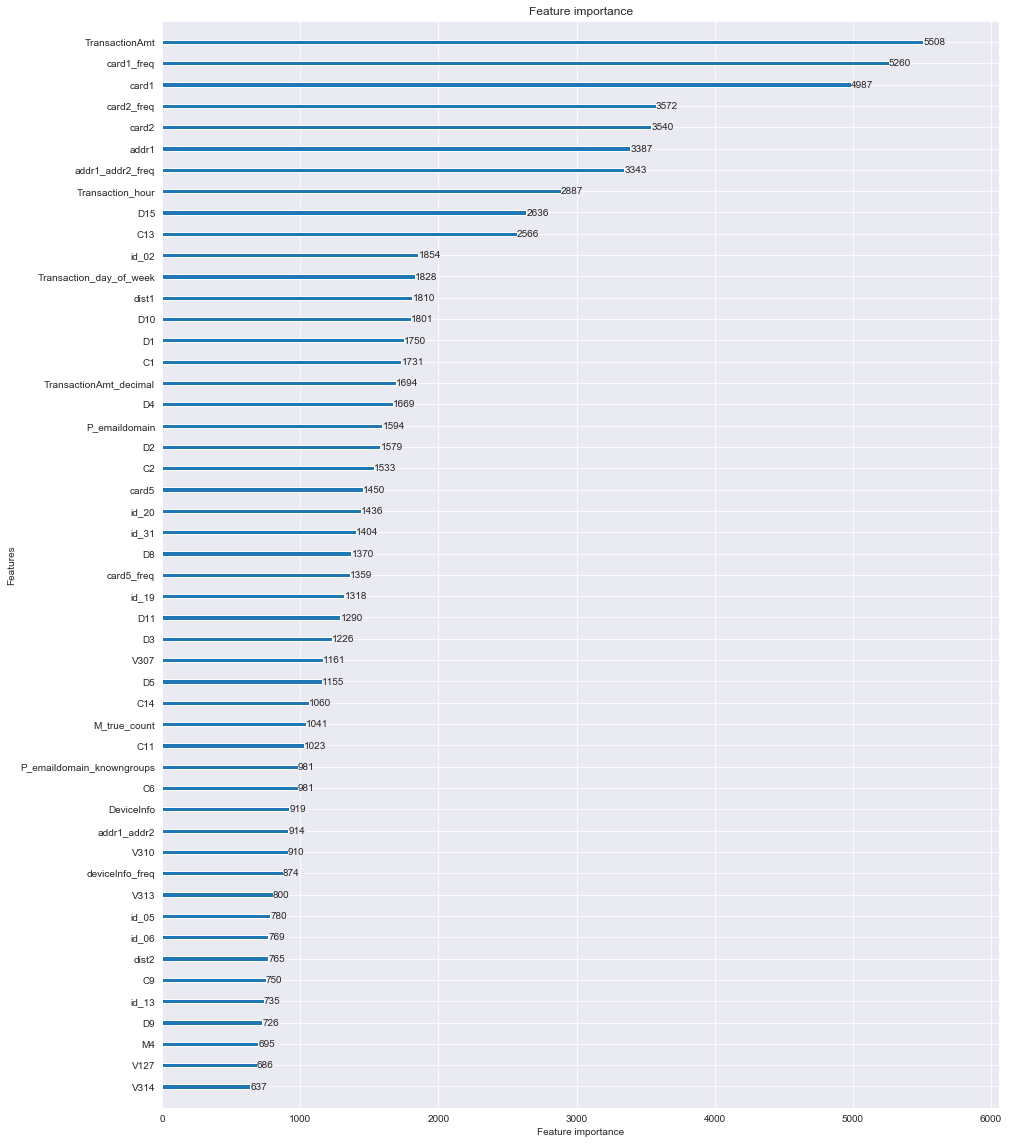

In [32]:
fig, ax = plt.subplots(figsize=(15, 20))
lgb.plot_importance(clf,max_num_features=50,ax=ax)
# for i in range(NFOLDS):
#     fig, ax = plt.subplots(figsize=(15, 20))
#     xgb.plot_importance(clfs[i],max_num_features=50,ax=ax)

In [33]:
sample_submission = pd.read_csv('data/sample_submission.csv', index_col='TransactionID')
sample_submission['isFraud'] = prediction
sample_submission.to_csv('data/lightgbm_459_feat.csv')